# imports

In [837]:
import datetime
import pandas as pd, numpy as np
import scipy
import matplotlib.pyplot as plt
from numpy_ext import rolling_apply as rolling_apply_ext

In [597]:
df = pd.read_csv('market_data_binance.by_minute_ALL_2022-09-19T04:00:00Z_2022-09-26T03:59:00Z.csv')
df['time'] = pd.to_datetime(df['timestamp'], unit='s')
df_close = df.pivot(index='time', columns='symbol', values='close')

In [550]:
def get_close_between_datetime(sample_period_minutes, symbols, start_datetime_str, end_datetime_str):   
    return df_close[(df_close.index >= start_datetime_str) & (df_close.index < end_datetime_str)][symbols].resample(f'{sample_period_minutes}min').last()

def get_close_between_date(sample_period_minutes, symbols, start_date_str, end_date_str):   
    return get_close_between_datetime(sample_period_minutes, symbols, start_date_str + " 00:00:000", end_date_str + " 00:00:000")

In [595]:
date_str_20220919 = "2022-09-19"
date_str_20220920 = "2022-09-20"
date_str_20220921 = "2022-09-21"
date_str_20220922 = "2022-09-22"
date_str_20220923 = "2022-09-23"
date_str_20220924 = "2022-09-24"
date_str_20220925 = "2022-09-25"
#symbols = ['YFIIUSDT', 'ETHUSDT', 'PAXGUSDT', 'BIFIUSDT', 'BNBUSDT']
symbols = ['YFIIUSDT', 'ETHUSDT', 'BIFIUSDT']

In [584]:
get_close_between_date(10, symbols, date_str_20220920, date_str_20220921)

symbol,YFIIUSDT,ETHUSDT,BIFIUSDT
time,,,
2022-09-20 00:00:00,893.5,1383.20,349.6
2022-09-20 00:10:00,886.7,1367.95,350.1
2022-09-20 00:20:00,886.3,1368.34,349.8
2022-09-20 00:30:00,884.1,1368.65,349.8
2022-09-20 00:40:00,880.3,1365.77,349.8
...,...,...,...
2022-09-20 23:10:00,863.7,1321.81,345.8
2022-09-20 23:20:00,866.6,1323.96,346.2
2022-09-20 23:30:00,863.3,1323.64,346.2


# Sanity check: eigen values, vectors

In [434]:
mat = [[1, 2, 0], [2, 1, 0], [0, 0, 4]]
eiven_vals, eigen_vecs = np.linalg.eig(mat)

In [227]:
eiven_vals

array([ 3., -1.,  4.])

In [228]:
eigen_vecs

array([[ 0.70710678, -0.70710678,  0.        ],
       [ 0.70710678,  0.70710678,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

The normalized (unit “length”) eigenvectors, such that the column v[:,i] is the eigenvector corresponding to the eigenvalue w[i].

In [229]:
eigen_vecs[:,0]

array([0.70710678, 0.70710678, 0.        ])

note that the matrix represenation is bit confusing. v[i,:] is *not* eigenvector, but v[:,i] is. So below is *not* an eigen vector.

In [230]:
eigen_vecs[0]

array([ 0.70710678, -0.70710678,  0.        ])

and accordingly the eigenvalues matix on the rhs is to be horizontally layed down.

In [231]:
eigen_vecs @ np.diag(eiven_vals) @ eigen_vecs.T

array([[1., 2., 0.],
       [2., 1., 0.],
       [0., 0., 4.]])

In [232]:
mat @ eigen_vecs[:,0]

array([2.12132034, 2.12132034, 0.        ])

# Solve the minimal predictability condition

In [552]:
get_close_between_date(10, symbols, "2022-09-19", "2022-09-21").corr().style.background_gradient(cmap='coolwarm')

symbol,YFIIUSDT,ETHUSDT,BIFIUSDT
symbol,,,
YFIIUSDT,1.000000,0.930983,0.824657
ETHUSDT,0.930983,1.000000,0.867188
BIFIUSDT,0.824657,0.867188,1.000000


In [553]:
get_close_between_date(1, symbols, "2022-09-19", "2022-09-21").corr().style.background_gradient(cmap='coolwarm')

symbol,YFIIUSDT,ETHUSDT,BIFIUSDT
symbol,,,
YFIIUSDT,1.000000,0.925849,0.821544
ETHUSDT,0.925849,1.000000,0.865456
BIFIUSDT,0.821544,0.865456,1.000000


In [555]:
get_close_between_date(10, symbols, "2022-09-19", "2022-09-24").corr().style.background_gradient(cmap='coolwarm')

symbol,YFIIUSDT,ETHUSDT,BIFIUSDT
symbol,,,
YFIIUSDT,1.000000,0.064190,0.479641
ETHUSDT,0.064190,1.000000,0.745906
BIFIUSDT,0.479641,0.745906,1.000000


In [556]:
get_close_between_date(1, symbols, "2022-09-19", "2022-09-24").corr().style.background_gradient(cmap='coolwarm')

symbol,YFIIUSDT,ETHUSDT,BIFIUSDT
symbol,,,
YFIIUSDT,1.000000,0.068271,0.480184
ETHUSDT,0.068271,1.000000,0.745821
BIFIUSDT,0.480184,0.745821,1.000000


the eigen_vecs are for calculation only, the actual distribution over the asset is returned in `wgts`.

In [235]:
def calc_autocov_matrix(arr, lag):
    m = arr.shape[0]  # sample size.
    arr_lead = arr[lag:]
    arr_lag = arr[:m-lag]
    return 1.0 / (m - lag - 1) * (arr_lead - np.nanmean(arr_lead, axis=0)).T @ (arr_lag - np.nanmean(arr_lag, axis=0))

In [625]:
def get_var1_wgts_values_transpose(*df_values_T):
    cov = np.cov(df_values_T)
    cov_inv = np.linalg.inv(cov)
    cov_inv_sqrt = scipy.linalg.sqrtm(cov_inv)
    autocov = calc_autocov_matrix(np.transpose(df_values_T), 1)
    #var_predictability = cov_inv_sqrt @ autocov @ cov @ autocov.T @ cov_inv_sqrt.T
    var_predictability = cov_inv_sqrt @ autocov @ cov_inv @ autocov.T @ cov_inv_sqrt.T

    var_eigen_vals, var_eigen_vecs = np.linalg.eig(var_predictability)

    asc = np.argsort(var_eigen_vals)
    var_eigen_vals, var_eigen_vecs = var_eigen_vals[asc], var_eigen_vecs[:, asc]
    wgts = cov_inv_sqrt @ var_eigen_vecs
    if np.sign((np.transpose(df_values_T) @ wgts[:,0])[-1]) < 0:
        pass # var_eigen_vecs, wgts = var_eigen_vecs * -1, wgts * -1
    if np.sign(wgts[-1,0]) < 0:
        var_eigen_vecs, wgts = var_eigen_vecs * -1, wgts * -1
    return var_eigen_vals, var_eigen_vecs, wgts

In [626]:
def get_var1_wgts(df):
    return get_var1_wgts_values_transpose(*df.values.T)

The same function that takes df.values.T instead of df itself. This is used in the custom rolling function as the custom rolling function does not take the data frame but the arrays.

# Portfolio construction

In [978]:
def add_features(values, wgt):
    values['value_prev'] = values.value.shift()
    values['lower_crossed_upward'] = ((values.value_prev < lower) & (values.value >= lower)).astype(np.int32)
    values['upper_crossed_downward'] = ((values.value_prev > upper) & (values.value <= upper)).astype(np.int32)
    in_positions = [0]
    for i in range(1, len(values.index)):
        in_position = in_positions[-1]
        if values.lower_crossed_upward.values[i-1] > 0:
            in_position = 1
        elif values.upper_crossed_downward.values[i-1] > 0:
            in_position = 0
        in_positions.append(in_position)
    values['in_position'] = in_positions
    values['profit'] = values.value.pct_change() * values.in_position
    values['position_changed'] = values.in_position.diff()
    #values = values.dropna()
    
    values['rebalanced'] = wgt.sum(axis=1).to_frame().diff().fillna(0)
    values = values.fillna(0)
    values['rebalanced'] = values[['rebalanced']].where(values.rebalanced == 0, 1)
    
    rebalance_ages = [1]
    for i in range(1, len(values.index)):
        rebalance_age = rebalance_ages[-1] + 1
        if values.rebalanced.values[i] > 0:
            rebalance_age = 1
        rebalance_ages.append(rebalance_age)
    values['rebalance_age'] = rebalance_ages

    return values

# Static Portfolio construction

In [861]:
var_eigen_vals, var_eigen_vecs, wgts = get_var1_wgts_values_transpose(*get_close_between_date(10, symbols, date_str_20220919, date_str_20220921).values.T)

In [862]:
var_eigen_vals

array([0.65533985, 0.69709114, 0.9545689 ])

In [863]:
print(var_eigen_vecs[:,0])
print(wgts[:,0])

[-0.06932741 -0.15607084  0.9853099 ]
[-0.01691221 -0.06233537  0.5031666 ]


In [864]:
print(var_eigen_vecs[:,-1])
print(wgts[:,-1])

[0.48917415 0.85547329 0.16992381]
[0.00727594 0.03155427 0.02976713]


In [990]:
get_close_between_date(10, symbols, date_str_20220919, date_str_20220921).head(3)

symbol,YFIIUSDT,ETHUSDT,BIFIUSDT
time,,,
2022-09-19 04:00:00,834.2,1300.92,340.1
2022-09-19 04:10:00,834.6,1303.61,340.1
2022-09-19 04:20:00,835.4,1303.85,343.0


## Graphs

<Axes: xlabel='time'>

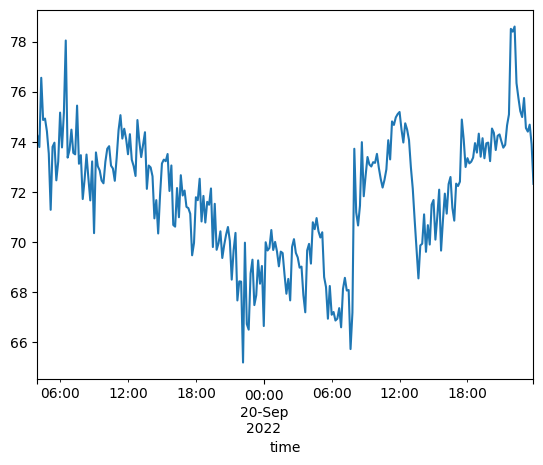

In [865]:
(get_close_between_date(10, symbols, date_str_20220919, date_str_20220921) * var_eigen_vecs[:,0]).sum(axis=1).plot()

<Axes: xlabel='time'>

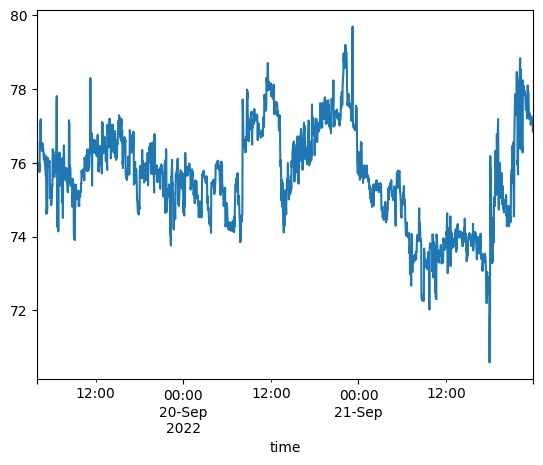

In [866]:
(get_close_between_date(2, symbols, date_str_20220919, date_str_20220922) * wgts[:,0]).sum(axis=1).plot()

## Bollinger bands trading

In [974]:
import talib
from talib import MA_Type

values = (get_close_between_date(1, symbols, date_str_20220919, date_str_20220922) * wgts[:,0]).sum(axis=1).copy().to_frame().rename(columns={0: 'value'})
upper, middle, lower = talib.BBANDS(values.value, 40, 2.0, matype=MA_Type.T3)
values['upper'] = upper
values['lower'] = lower

<Axes: xlabel='time'>

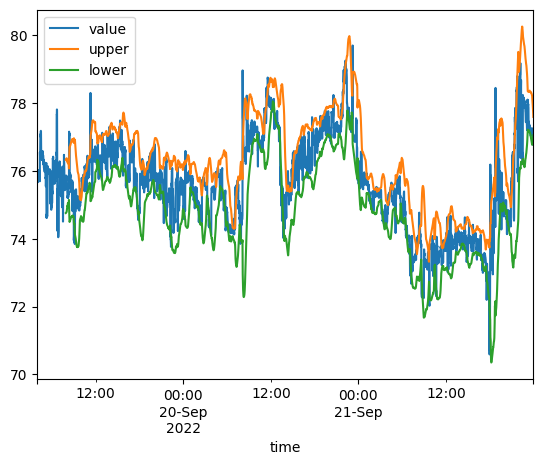

In [975]:
#upper.plot()
#middle.plot()
#lower.plot()
values[['value', 'upper', 'lower']].plot()

In [987]:
type(wgts[:,0])

numpy.ndarray

In [979]:
values = add_features(values, wgts[:,0])

AxisError: axis 1 is out of bounds for array of dimension 1

In [880]:
values['value_prev'] = values.value.shift()
values['lower_crossed_upward'] = ((values.value_prev < lower) & (values.value >= lower)).astype(np.int32)
values['lower_crossed_downward'] = ((values.value_prev > lower) & (values.value <= lower)).astype(np.int32)
values['upper_crossed_downward'] = ((values.value_prev > upper) & (values.value <= upper)).astype(np.int32)
values['upper_crossed_upward'] = ((values.value_prev < upper) & (values.value >= upper)).astype(np.int32)
in_positions = [0]
for i in range(1, len(values.index)):
    in_position = in_positions[-1]
    if values.lower_crossed_upward.values[i-1] > 0:
        in_position = 1
    elif values.upper_crossed_downward.values[i-1] > 0:
        in_position = 0
    in_positions.append(in_position)
values['in_position'] = in_positions
values['position_changed'] = values.in_position.diff()
values['profit'] = values.value.pct_change() * values.in_position
#values = values.dropna()

<Axes: xlabel='time'>

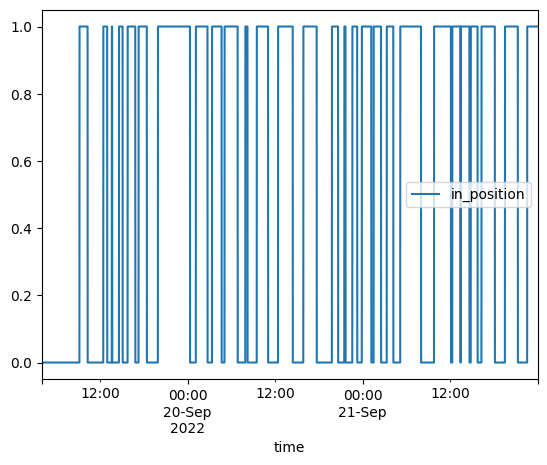

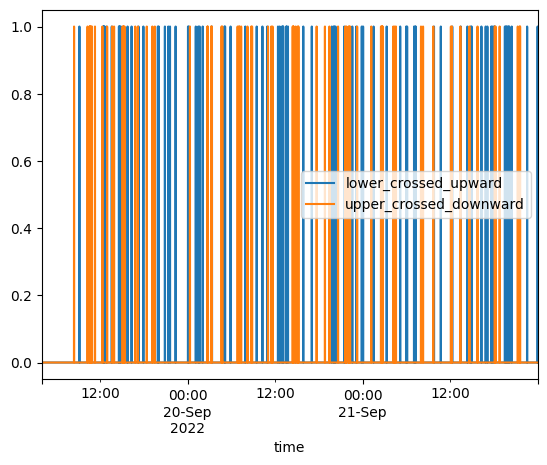

In [881]:
values[['in_position']].plot()
values[['lower_crossed_upward', 'upper_crossed_downward']].plot()

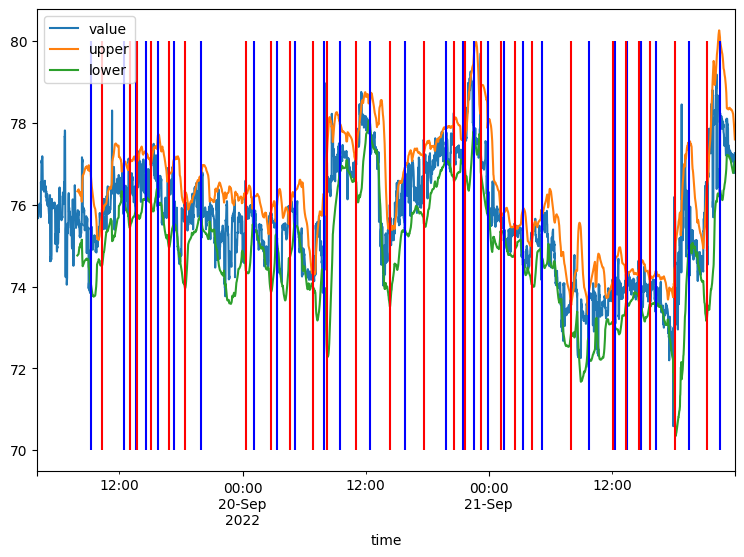

In [890]:
# plot dataframe; the index is a datetime index
ax = values[['value', 'upper', 'lower']].plot(figsize=(9, 6))

# add vertical lines
ax.vlines(x=list(values[values.position_changed == +1].index), ymin=70, ymax=80, color='b', label='test lines')
ax.vlines(x=list(values[values.position_changed == -1].index), ymin=70, ymax=80, color='r', label='test lines')

plt.show()

<Axes: xlabel='time'>

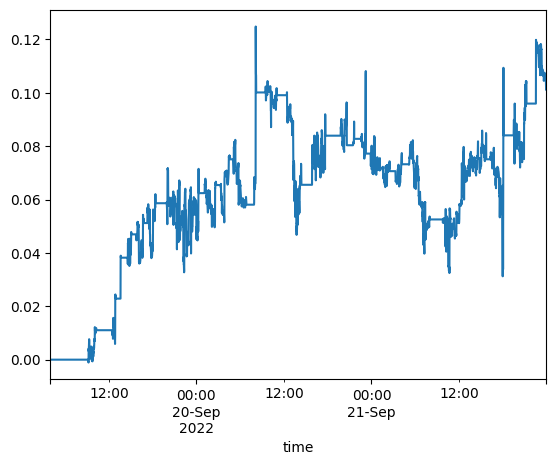

In [891]:
values.profit.cumsum().plot()

<Axes: xlabel='time'>

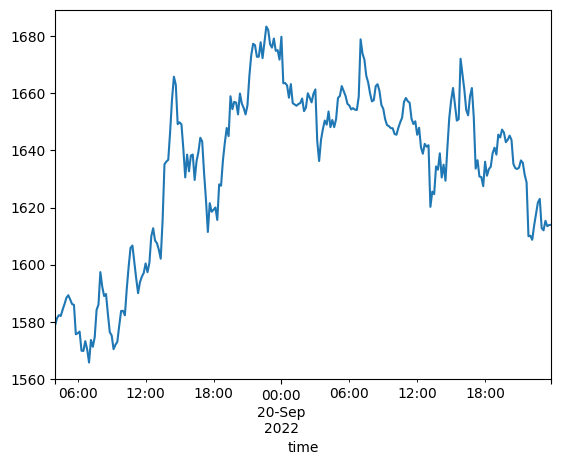

In [581]:
(get_close_between_date(10, symbols, "2022-09-19", "2022-09-21") * var_eigen_vecs[:,-1]).sum(axis=1).plot()

<Axes: xlabel='time'>

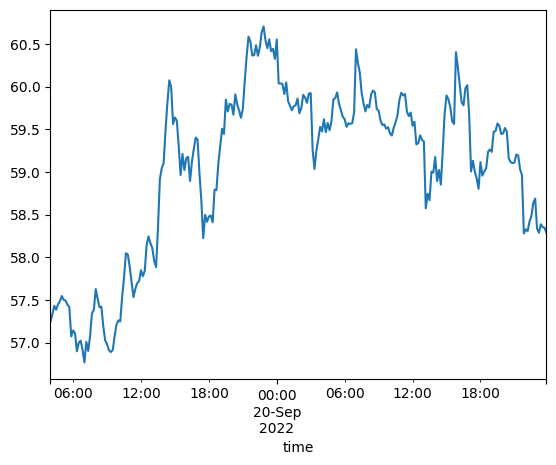

In [582]:
(get_close_between_date(10, symbols, "2022-09-19", "2022-09-21") * wgts[:,-1]).sum(axis=1).plot()

<Axes: xlabel='time'>

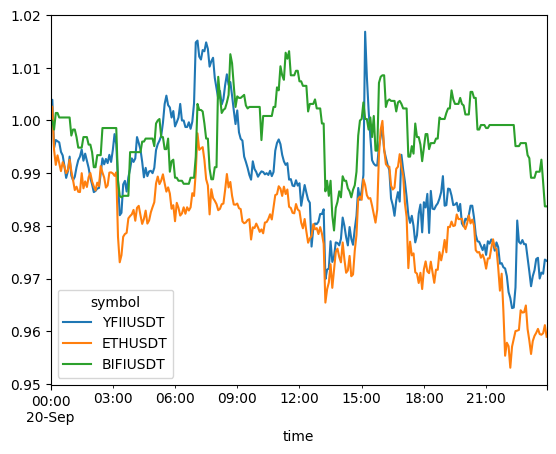

In [577]:
df = get_close_between_date(5, symbols, "2022-09-20", "2022-09-21")
(df / df.iloc[0]).plot()

# Rolling-based Portfolio Construction

In [775]:
from numpy_ext import rolling_apply as rolling_apply_ext

In [895]:
def get_df_var1_eigenvecs_weights(df, window, step, sample_unit_minutes, order, if_evecs):
    '''
    order: 0 for the smallest eigen value, -1 for the largest.
    '''
    i = 1 if if_evecs else 2
    rolling_wgt = rolling_apply_ext(lambda *vsT: get_var1_wgts_values_transpose(*vsT)[i][:,order], window, *df.values.T)
    df_rolling_wgt = pd.DataFrame(rolling_wgt, index=df.index, columns=df.columns)
    df_rolling_wgt_resampled = df_rolling_wgt.resample(f'{step * sample_unit_minutes}min').first().resample(f'{sample_unit_minutes}min').first().ffill()
    return df_rolling_wgt_resampled

In [896]:
rebalance_period = 1
wgt_rolling = get_df_var1_eigenvecs_weights(
    get_close_between_date(1, symbols, date_str_20220919, date_str_20220922), 
    window=144, step=rebalance_period, sample_unit_minutes=1, order=0, if_evecs=False)

In [993]:
wgt_rolling.dropna().head(3)

symbol,YFIIUSDT,ETHUSDT,BIFIUSDT
time,,,
2022-09-19 06:23:00,0.283563,-0.410268,0.773823
2022-09-19 06:24:00,0.282107,-0.404585,0.786730
2022-09-19 06:25:00,0.276620,-0.399562,0.795142


<Axes: xlabel='time'>

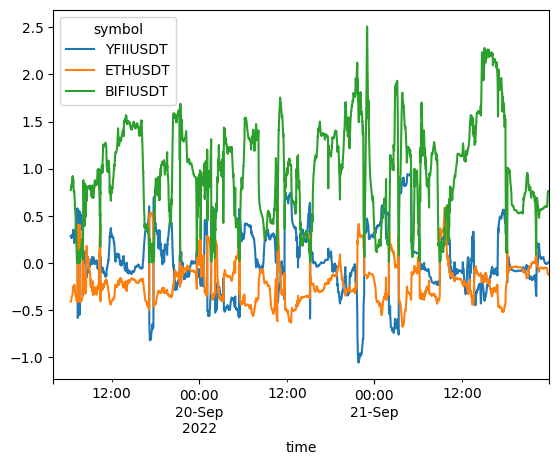

In [897]:
wgt_rolling.plot()

In [994]:
get_close_between_date(1, symbols, date_str_20220919, date_str_20220922).head(3)

symbol,YFIIUSDT,ETHUSDT,BIFIUSDT
time,,,
2022-09-19 04:00:00,833.1,1297.49,339.5
2022-09-19 04:01:00,832.1,1296.67,339.5
2022-09-19 04:02:00,832.3,1296.28,339.6


<Axes: xlabel='time'>

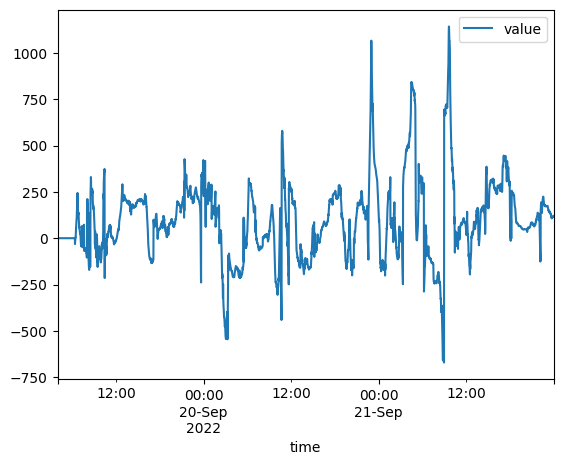

In [898]:
(get_close_between_date(1, symbols, date_str_20220919, date_str_20220922) * wgt_rolling).sum(axis=1).to_frame().rename(columns={0: 'value'}).plot()

In [932]:
import talib
from talib import MA_Type

values_rolling = (get_close_between_date(1, symbols, date_str_20220919, date_str_20220922) * wgt_rolling).sum(axis=1).to_frame().rename(columns={0: 'value'})
upper, middle, lower = talib.BBANDS(values_rolling.value, 40, 2.0, matype=MA_Type.T3)
values_rolling['upper'] = upper
values_rolling['lower'] = lower

<Axes: xlabel='time'>

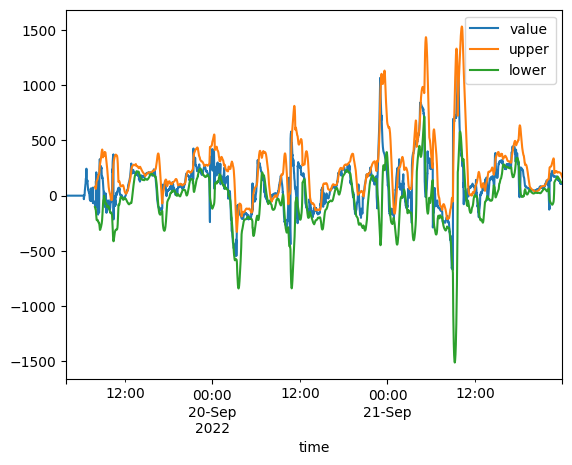

In [933]:
values_rolling[['value', 'upper', 'lower']].plot()

In [951]:
values_rolling = add_features(values_rolling, wgt_rolling)

<Axes: xlabel='time'>

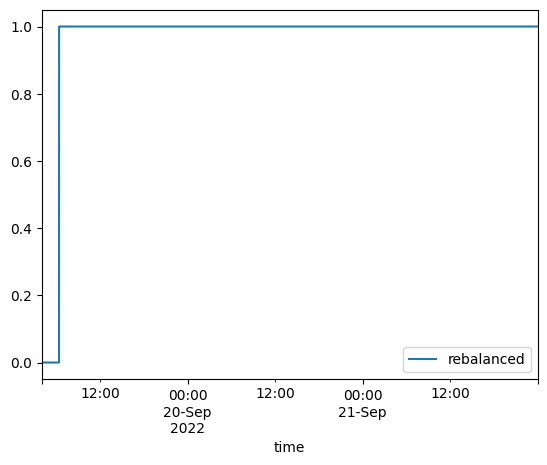

In [953]:
values_rolling[['rebalanced']].plot()

<Axes: xlabel='time'>

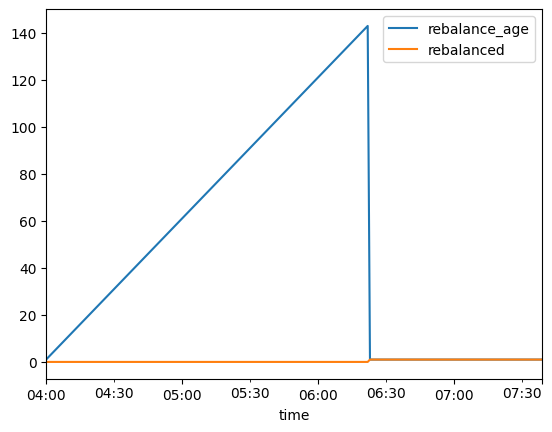

In [954]:
values_rolling[['rebalance_age', 'rebalanced']].iloc[:220].plot()

<Axes: xlabel='time'>

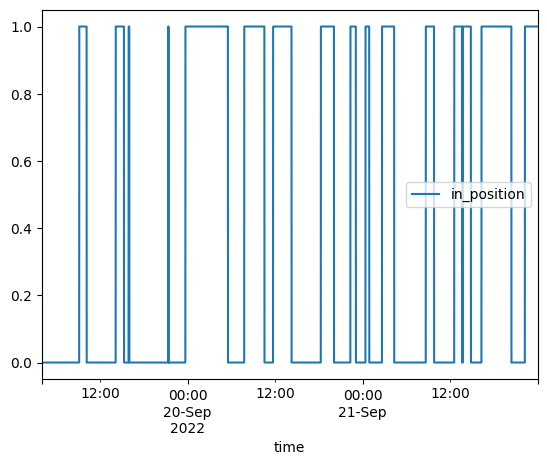

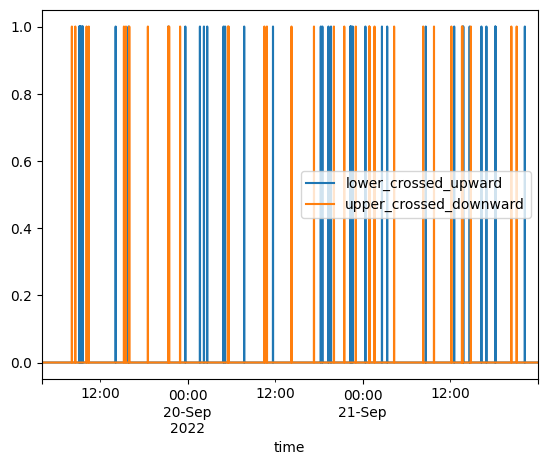

In [955]:
values_rolling[['in_position']].plot()
values_rolling[['lower_crossed_upward', 'upper_crossed_downward']].plot()

In [967]:
values_rolling[values_rolling.in_position == 1]

,value,upper,lower,value_prev,lower_crossed_upward,upper_crossed_downward,in_position,profit,rebalanced,rebalance_age,position_changed
time,,,,,,,,,,,
2022-09-19 09:09:00,36.126906,358.553180,-0.688440,13.015601,0,0,1,1.775662,1.0,1,1.0
2022-09-19 09:10:00,-26.717926,370.759162,-10.860569,36.126906,0,0,1,-1.739558,1.0,1,0.0
2022-09-19 09:11:00,-6.510357,378.277746,-17.475970,-26.717926,1,0,1,-0.756330,1.0,1,0.0
2022-09-19 09:12:00,-54.682201,387.455760,-26.907005,-6.510357,0,0,1,7.399262,1.0,1,0.0
2022-09-19 09:13:00,-38.204778,391.656539,-32.503980,-54.682201,0,0,1,-0.301331,1.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-09-21 23:55:00,117.114420,173.987428,117.434149,114.863458,0,0,1,0.019597,1.0,1,0.0
2022-09-21 23:56:00,117.679927,171.341858,116.561616,117.114420,0,0,1,0.004829,1.0,1,0.0
2022-09-21 23:57:00,118.372763,168.843697,115.599233,117.679927,0,0,1,0.005887,1.0,1,0.0


In [972]:
values_rolling.head(330).tail(25)

,value,upper,lower,value_prev,lower_crossed_upward,upper_crossed_downward,in_position,profit,rebalanced,rebalance_age,position_changed
time,,,,,,,,,,,
2022-09-19 09:05:00,38.401391,376.907787,-38.535470,47.938314,0,0,0,-0.000000,1.0,1,0.0
2022-09-19 09:06:00,2.704109,385.027156,-40.075853,38.401391,0,0,0,-0.000000,1.0,1,0.0
2022-09-19 09:07:00,-33.893622,386.344252,-35.951742,2.704109,0,0,0,-0.000000,1.0,1,0.0
2022-09-19 09:08:00,13.015601,367.945921,-13.259309,-33.893622,1,0,0,-0.000000,1.0,1,0.0
2022-09-19 09:09:00,36.126906,358.553180,-0.688440,13.015601,0,0,1,1.775662,1.0,1,1.0
2022-09-19 09:10:00,-26.717926,370.759162,-10.860569,36.126906,0,0,1,-1.739558,1.0,1,0.0
2022-09-19 09:11:00,-6.510357,378.277746,-17.475970,-26.717926,1,0,1,-0.756330,1.0,1,0.0
2022-09-19 09:12:00,-54.682201,387.455760,-26.907005,-6.510357,0,0,1,7.399262,1.0,1,0.0
2022-09-19 09:13:00,-38.204778,391.656539,-32.503980,-54.682201,0,0,1,-0.301331,1.0,1,0.0


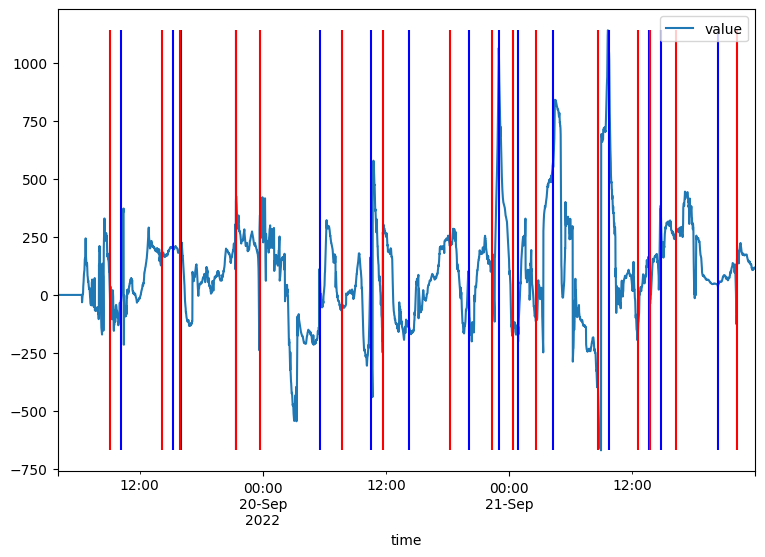

In [962]:
# plot dataframe; the index is a datetime index
#ax = values_rolling[['value', 'upper', 'lower']].plot(figsize=(9, 6))
ax = values_rolling[['value']].plot(figsize=(9, 6))
ymin, ymax = values_rolling.value.min(), values_rolling.value.max()

# add vertical lines
ax.vlines(x=list(values_rolling[values_rolling.position_changed == -1].index), ymin=ymin, ymax=ymax, color='b', label='test lines')
ax.vlines(x=list(values_rolling[values_rolling.position_changed == +1].index), ymin=ymin, ymax=ymax, color='r', label='test lines')

plt.show()

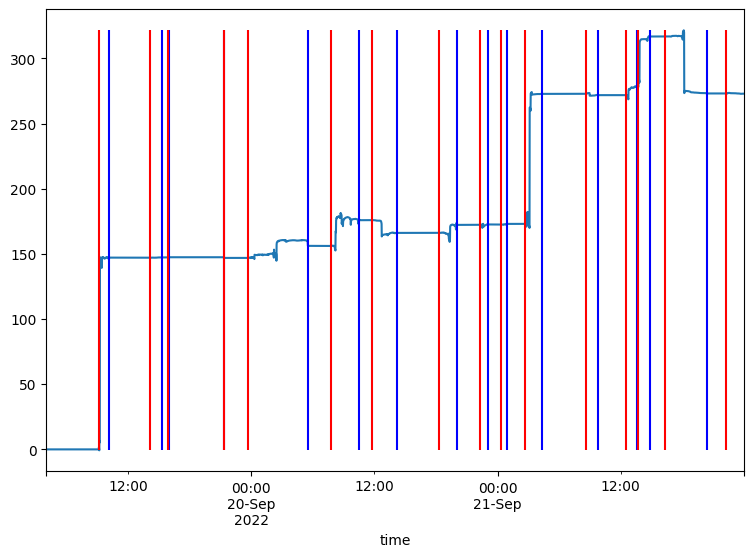

In [963]:
ax = values.profit.cumsum().plot(figsize=(9, 6))
ymin, ymax = values.profit.cumsum().min(), values.profit.cumsum().max()

# add vertical lines
ax.vlines(x=list(values_rolling[values_rolling.position_changed == -1].index), ymin=ymin, ymax=ymax, color='b', label='test lines')
ax.vlines(x=list(values_rolling[values_rolling.position_changed == +1].index), ymin=ymin, ymax=ymax, color='r', label='test lines')

plt.show()

<Axes: xlabel='time'>

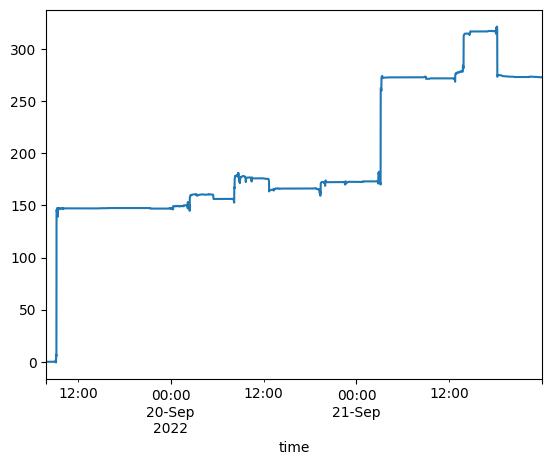

In [809]:
values.profit.cumsum().plot()